In [ ]:
pip install sweetviz phik

Note: you may need to restart the kernel to use updated packages.


# Прогнозирование температуры звезды

**Цель работы:** разработать нейронную сеть, которая поможет предсказывать абсолютную температуру на поверхности звезды. Входные данные - база обсерватории с инофрмацией о 240 звездах.

 Обычно для расчёта температуры учёные пользуются следующими методами:
- Закон смещения Вина.
- Закон Стефана-Больцмана.
- Спектральный анализ.

**План работы:**
- [x]  Загрузить данные
- [x]  Выполнить предобработку и исследовательский анализ данных
- [x]  Выполнить подготовку данных для построение модели
- [x]  Построить простую модель нейронной сети — baseline
- [x]  Произвести улучшение сети
- [x]  Сделать общий вывод

## Загрузка данных

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sweetviz as sv
import phik
import torch
import torch.nn as nn

from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from math import ceil

In [ ]:
df = pd.read_csv('/datasets/6_class.csv')

In [ ]:
print(df.info())
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              240 non-null    int64  
 1   Temperature (K)         240 non-null    int64  
 2   Luminosity(L/Lo)        240 non-null    float64
 3   Radius(R/Ro)            240 non-null    float64
 4   Absolute magnitude(Mv)  240 non-null    float64
 5   Star type               240 non-null    int64  
 6   Star color              240 non-null    object 
dtypes: float64(3), int64(3), object(1)
memory usage: 13.2+ KB
None


,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,0,3068,0.002400,0.1700,16.12,0,Red
1,1,3042,0.000500,0.1542,16.60,0,Red
2,2,2600,0.000300,0.1020,18.70,0,Red
3,3,2800,0.000200,0.1600,16.65,0,Red
4,4,1939,0.000138,0.1030,20.06,0,Red
5,5,2840,0.000650,0.1100,16.98,0,Red
6,6,2637,0.000730,0.1270,17.22,0,Red
7,7,2600,0.000400,0.0960,17.40,0,Red
8,8,2650,0.000690,0.1100,17.45,0,Red
9,9,2700,0.000180,0.1300,16.05,0,Red


**Вывод по первому шагу:** загрузили данные о звездах.

Представленный датафрейм состоит из 240 строк и 7 столбцов, 3 из которых имеют тип float64, 3 - int64, 1 - object. Пропуски в колонках на первый взгляд отсутствуют. Столбец `Unnamed: 0` выглядит лишним, подробнее рассмотрим его в ледующем пункте. Далее перейдем к предобработке и исследовательскому анализу данных.

## Предобработка и анализ данных

Рассмотрим столбец `Unnamed: 0`.

In [ ]:
df['Unnamed: 0'].nunique()

240

In [ ]:
df['Unnamed: 0'].tail()

235    235
236    236
237    237
238    238
239    239
Name: Unnamed: 0, dtype: int64

Столбец `Unnamed: 0` содержит номера по порядку и повторяет индексы. Избавимся от него.

In [ ]:
df = df.drop('Unnamed: 0', axis=1)

Рассмотрим данные на наличие явных дубликатов.

In [ ]:
df.duplicated().sum()

0

Явные дубликаты отсутствуют.

In [ ]:
df['Star type'].unique()

array([0, 1, 2, 3, 4, 5])

In [ ]:
df['Star color'].unique()

array(['Red', 'Blue White', 'White', 'Yellowish White', 'Blue white',
       'Pale yellow orange', 'Blue', 'Blue-white', 'Whitish',
       'yellow-white', 'Orange', 'White-Yellow', 'white', 'Blue ',
       'yellowish', 'Yellowish', 'Orange-Red', 'Blue white ',
       'Blue-White'], dtype=object)

В признаке `Star color` наблюдаются неявные дубликаты. Устраним их.

In [ ]:
df['Star color'] = df['Star color'].apply(lambda x: x.strip())
df['Star color'] = df['Star color'].apply(lambda x: x.replace(' ', '-'))
df['Star color'] = df['Star color'].apply(lambda x: x.lower())
df['Star color'] = df['Star color'].apply(lambda x: x.replace('yellow-white', 'white-yellow'))

In [ ]:
df['Star color'].value_counts()

red                   112
blue                   56
blue-white             41
white                  10
white-yellow            9
yellowish               3
yellowish-white         3
whitish                 2
orange                  2
orange-red              1
pale-yellow-orange      1
Name: Star color, dtype: int64

Звезд цветов `yellowish, yellowish-white, whitish, orange, orange-red, pale-yellow-orange` сдишком мало(3 и менее каждого цвета), объединим их в категорию `other`.

In [ ]:
other_list = ['yellowish','yellowish-white', 'whitish', 'orange', 'orange-red', 'pale-yellow-orange']
df['Star color'] = df['Star color'].apply(lambda x: x.replace(x, 'other') if x in other_list else x)

In [ ]:
df['Star color'].value_counts()

red             112
blue             56
blue-white       41
other            12
white            10
white-yellow      9
Name: Star color, dtype: int64

In [ ]:
df['Star color'].unique()

array(['red', 'blue-white', 'white', 'other', 'blue', 'white-yellow'],
      dtype=object)

Явно выделим числовые и категориальные признаки.

In [ ]:
num_cols = ['Luminosity(L/Lo)',
            'Radius(R/Ro)',
            'Absolute magnitude(Mv)']
cat_cols = ['Star type',
            'Star color']
target = ['Temperature (K)']

Рассмотрим числовые признаки на предмет выбросов и аномалий.

In [ ]:
df[num_cols].describe()

,Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv)
count,240.000000,240.000000,240.000000
mean,107188.361635,237.157781,4.382396
std,179432.244940,517.155763,10.532512
min,0.000080,0.008400,-11.920000
25%,0.000865,0.102750,-6.232500
50%,0.070500,0.762500,8.313000
75%,198050.000000,42.750000,13.697500
max,849420.000000,1948.500000,20.060000


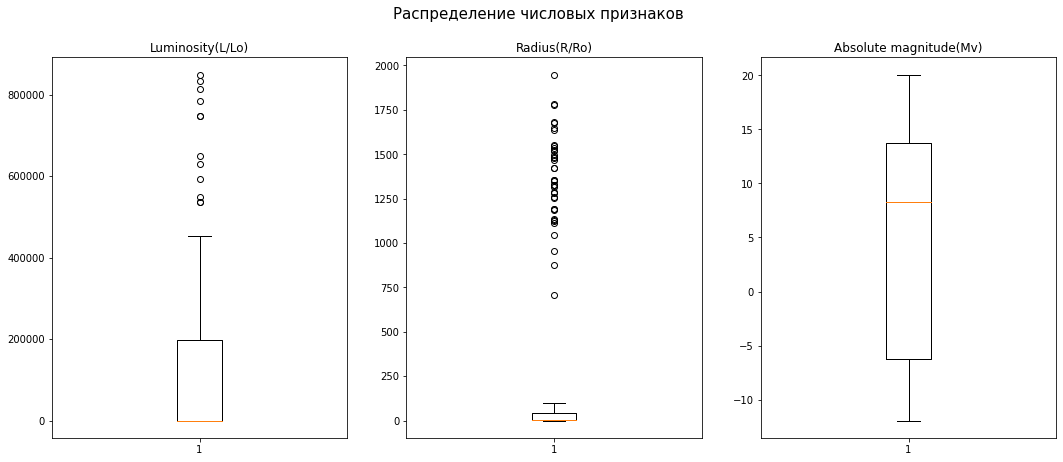

In [ ]:
fig, axs = plt.subplots(1, 3)
ax = axs.ravel()
plt.figure
fig.suptitle('Распределение числовых признаков', fontsize=15)
fig.set_size_inches(18, 7)
for i, num in enumerate(num_cols):
    ax[i].boxplot(df[num])
    ax[i].set_title(num)
plt.show()

Построим корреляционную матрицу для исследование зависимостей между признаками.

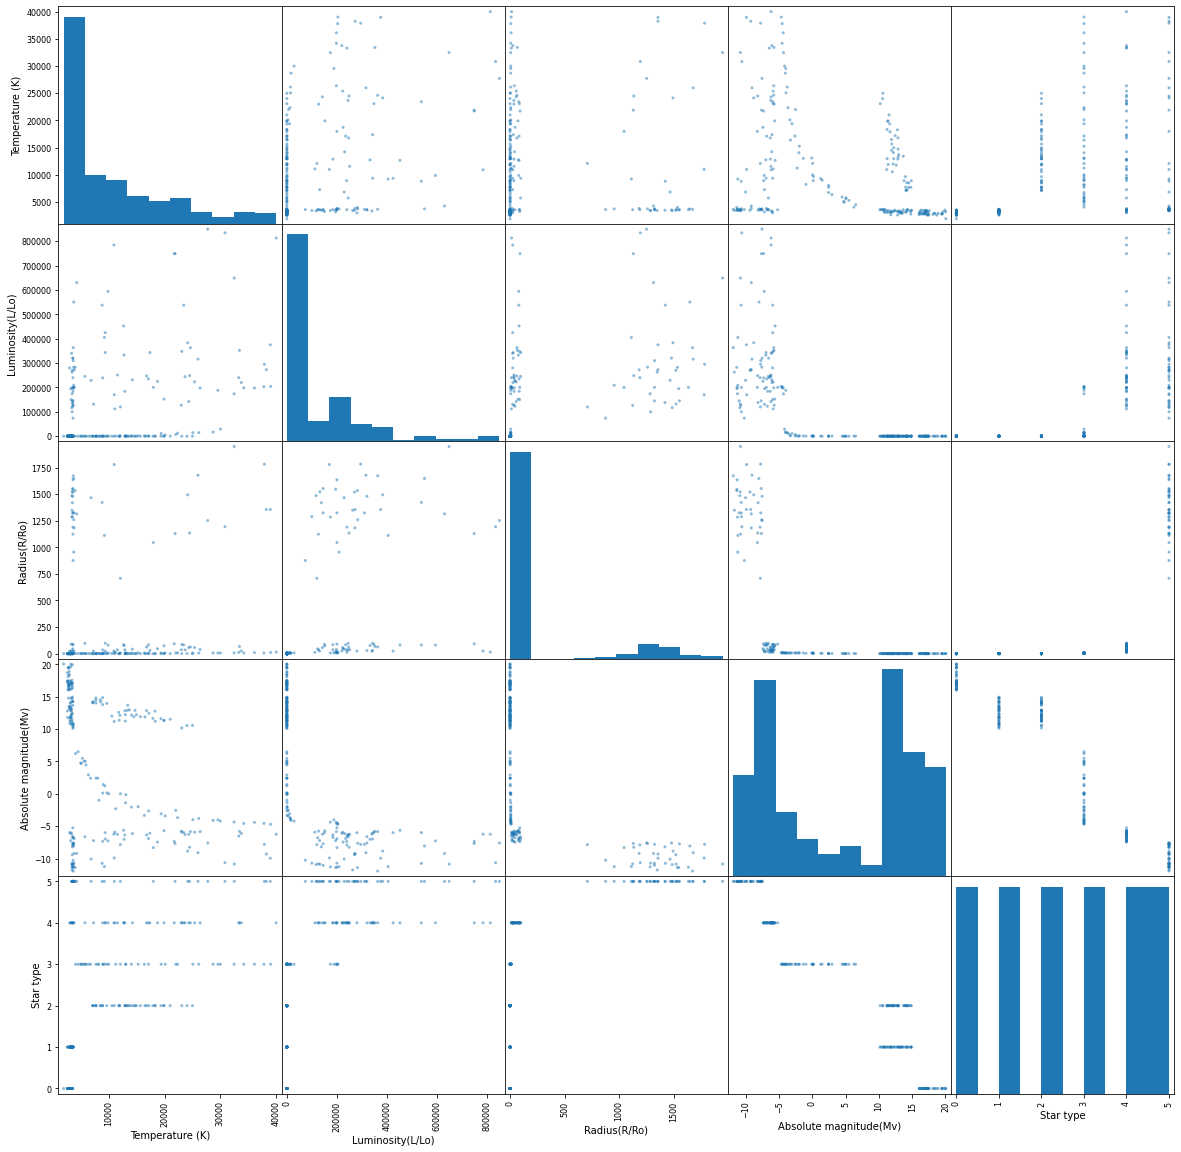

In [ ]:
pd.plotting.scatter_matrix(df, figsize=(20, 20));

Рассмотрим корреляцию признаков методами библиотеки `phik`.

interval columns not set, guessing: ['Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)', 'Star type']


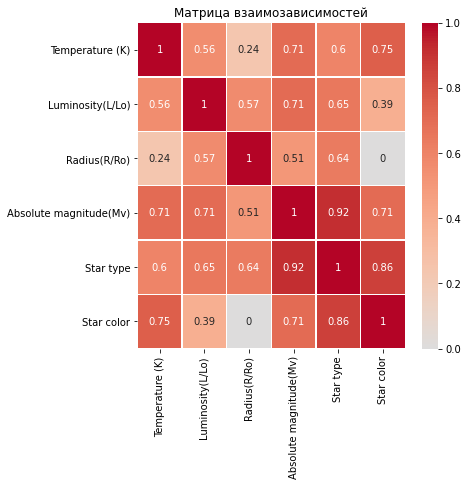

In [ ]:
phik_overview = df.phik_matrix()
plt.figure(figsize=(6, 6))
corr_matrix = phik_overview
corr_matrix = np.round(corr_matrix, 2)
sns.heatmap(corr_matrix, annot=True, linewidth= 0.3, cmap='coolwarm', center=0)
plt.title('Матрица взаимозависимостей')
plt.show()

Проведем исследовательский анализ данных при помощи библиотеки `sweetviz`.

                                             |          | [  0%]   00:00 -> (? left)


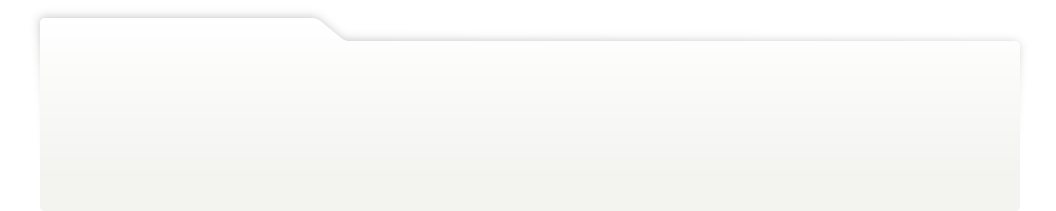
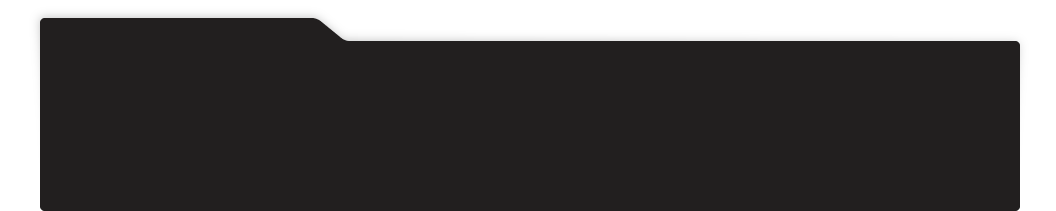
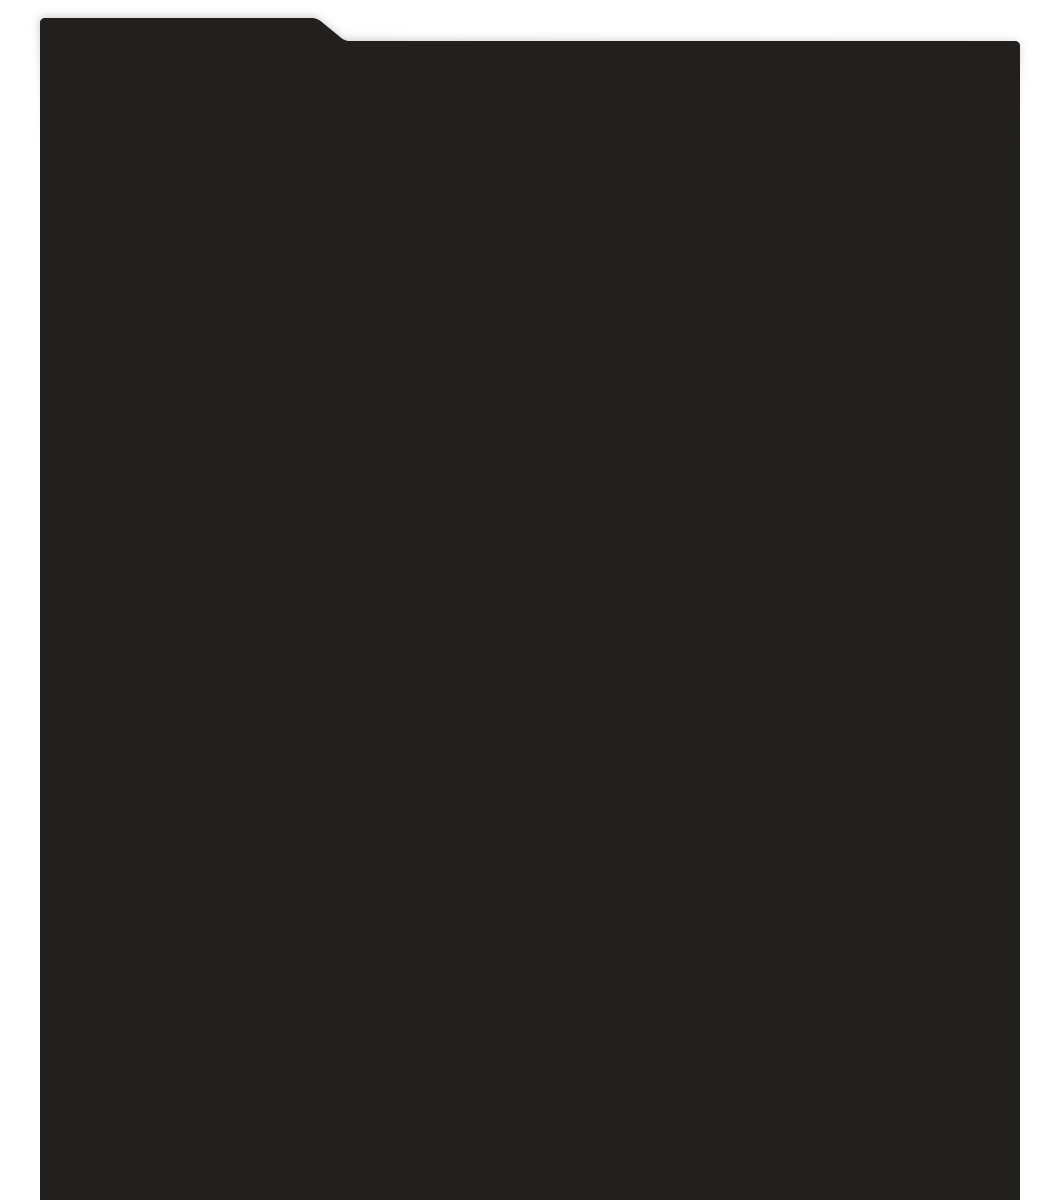
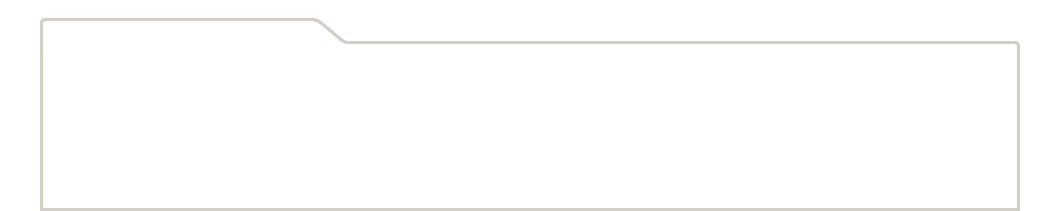
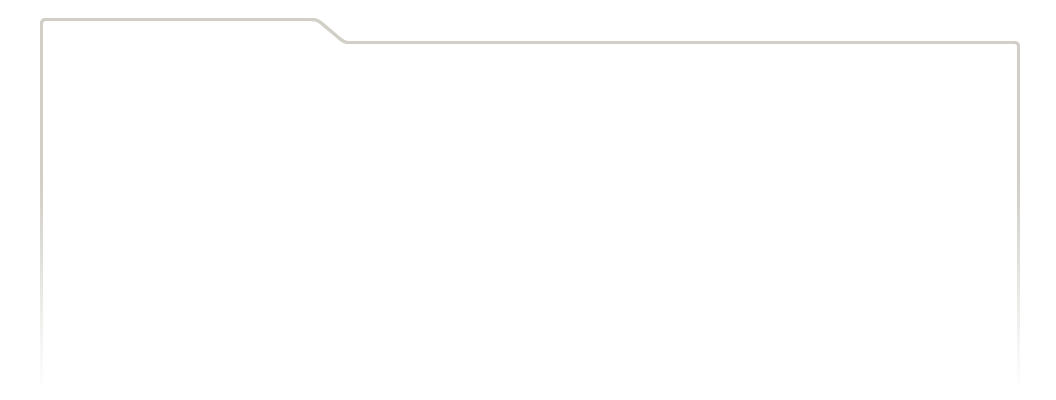
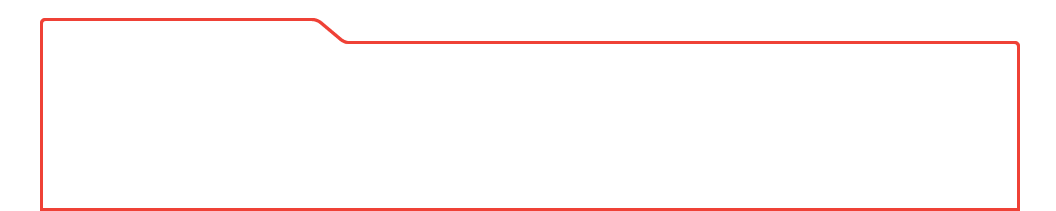
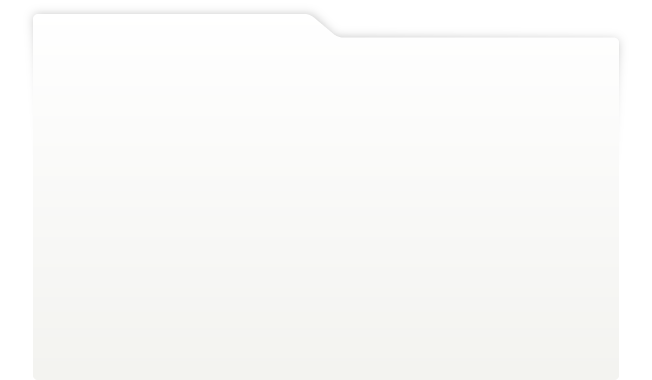
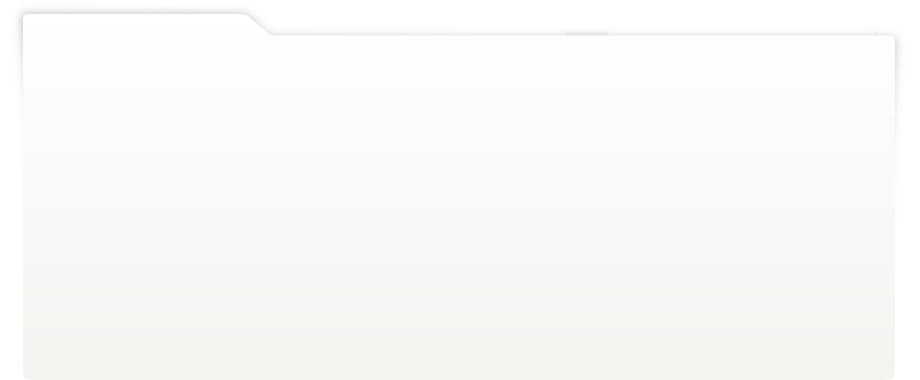
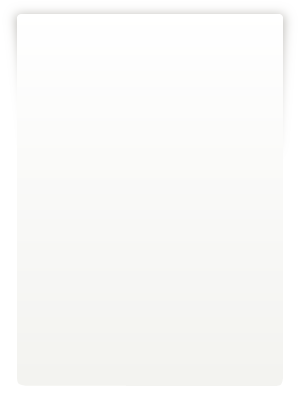
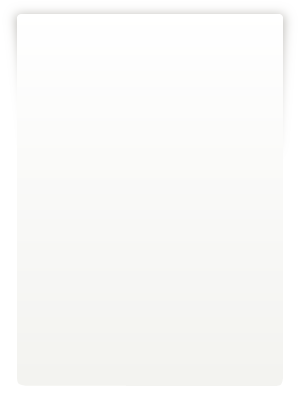
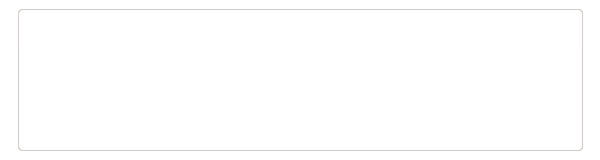
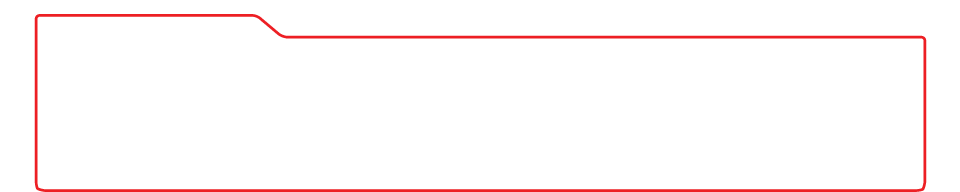
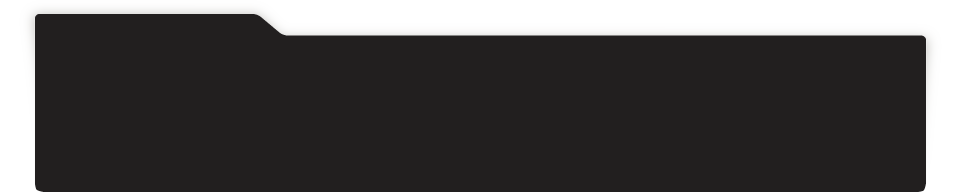
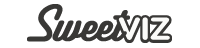
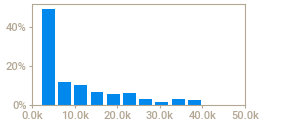
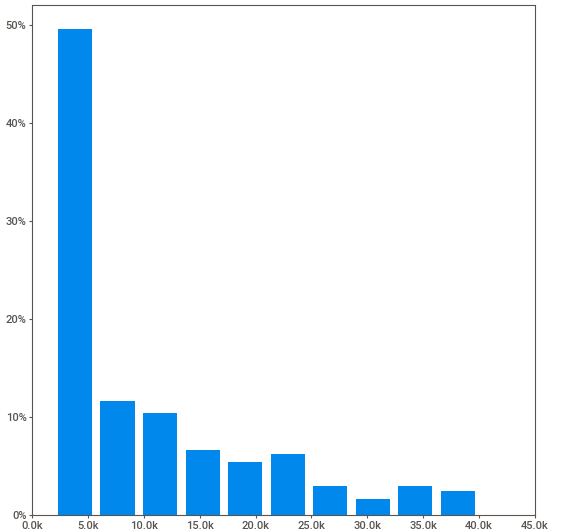
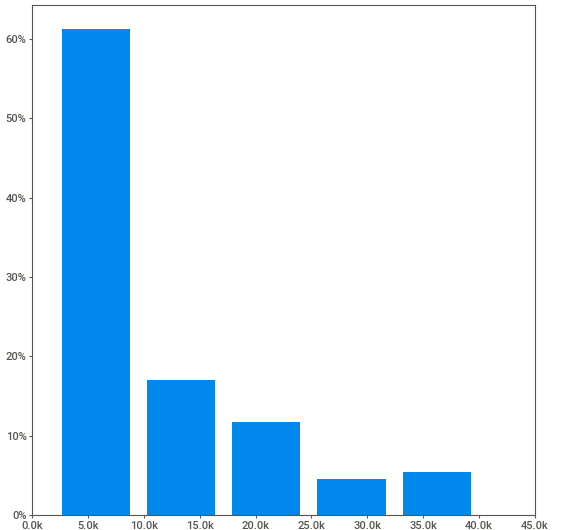
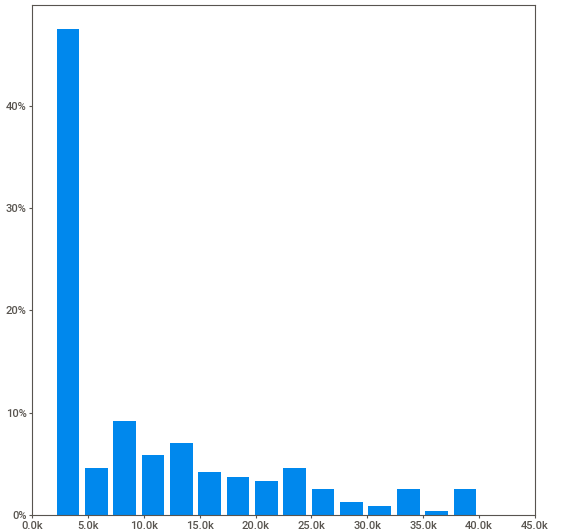
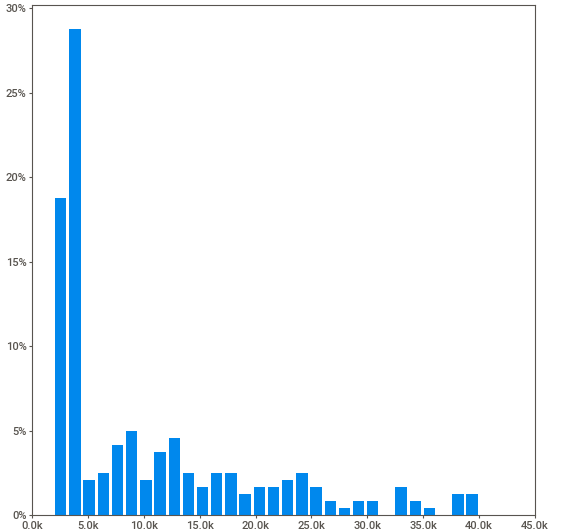
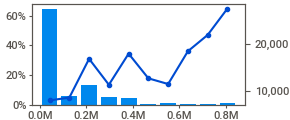
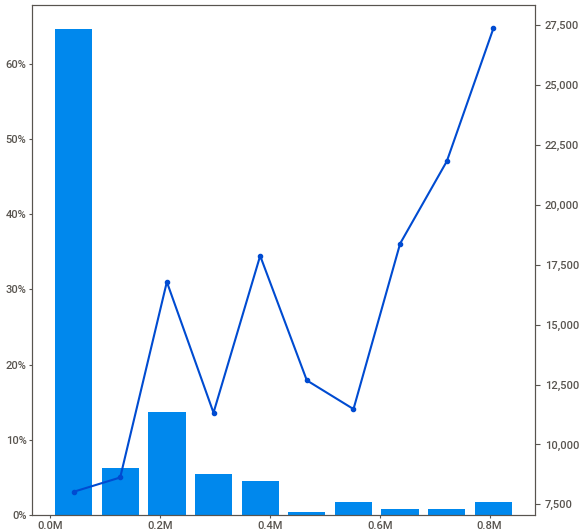
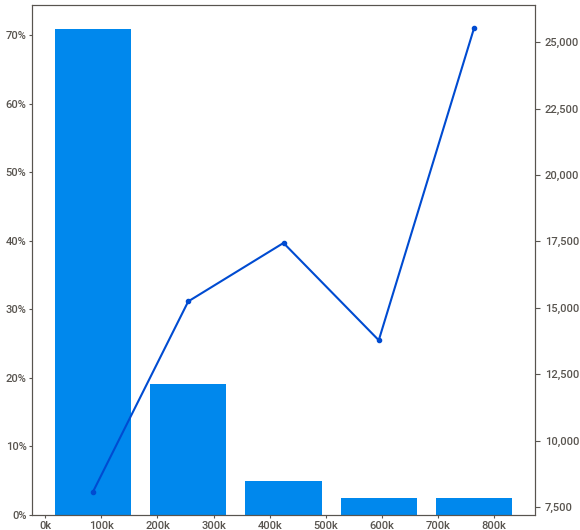
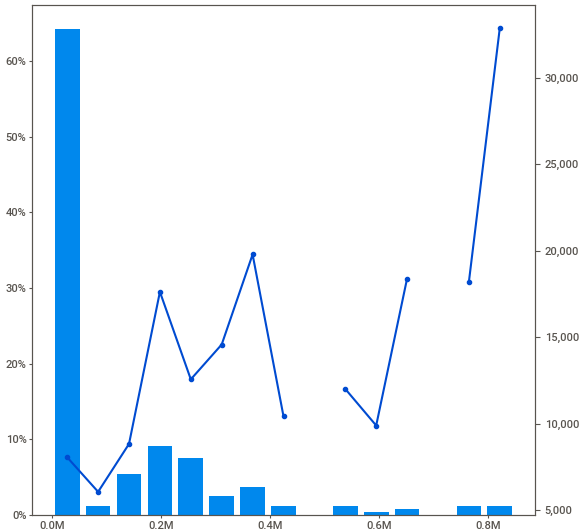
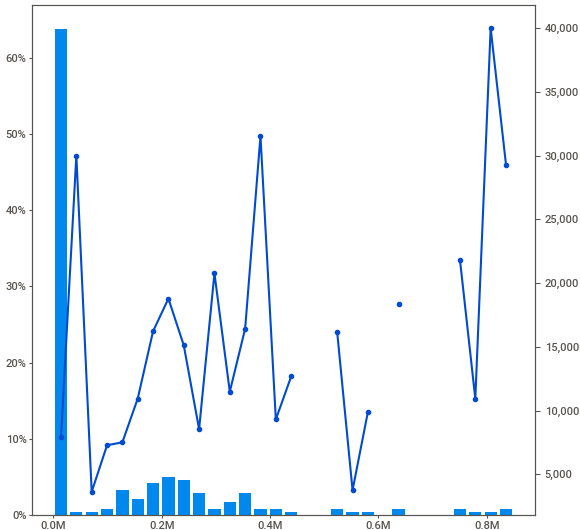
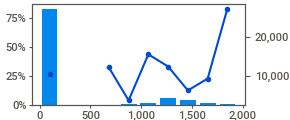
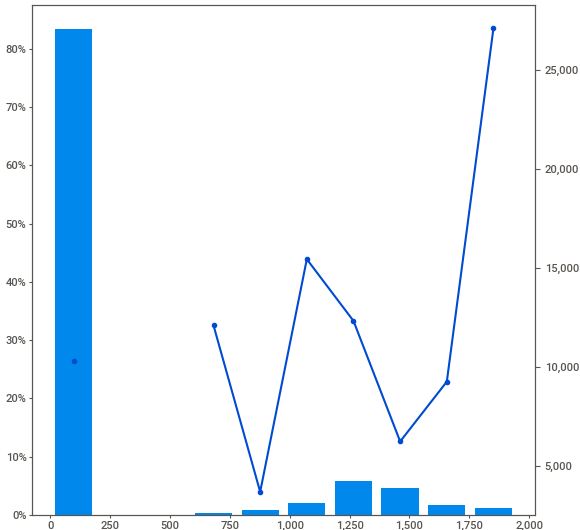
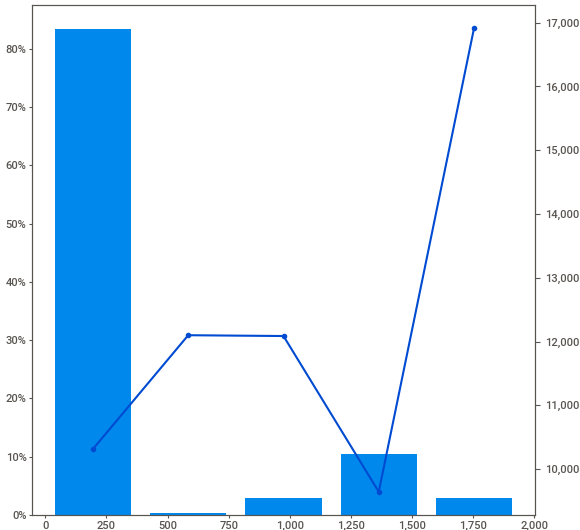
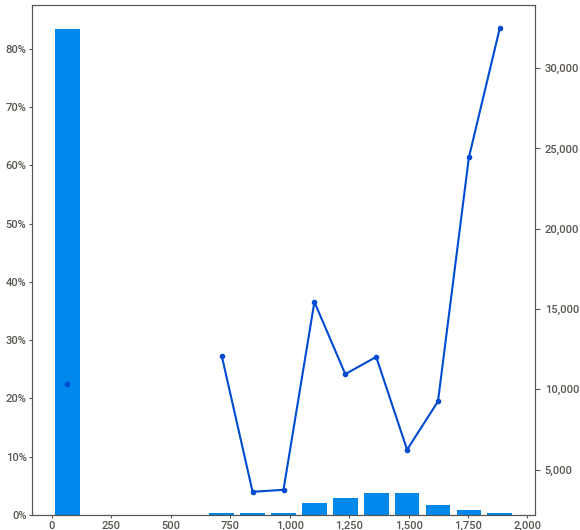
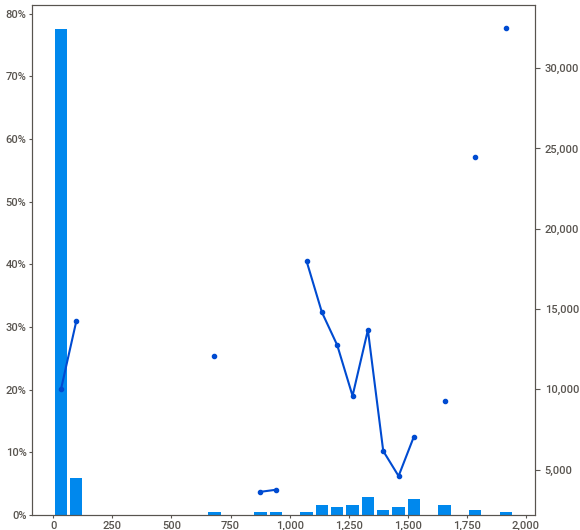
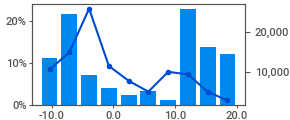
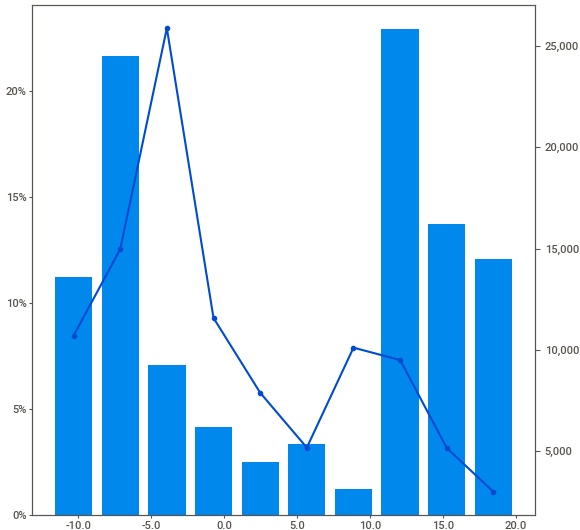
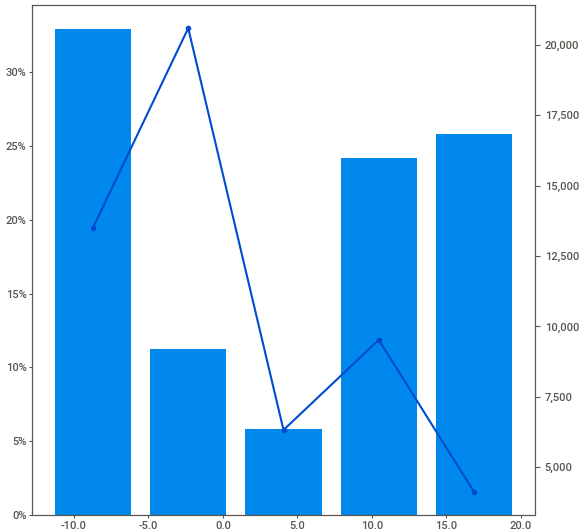
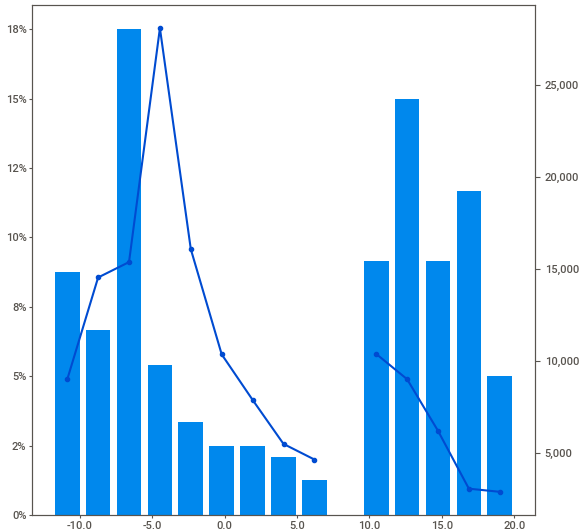
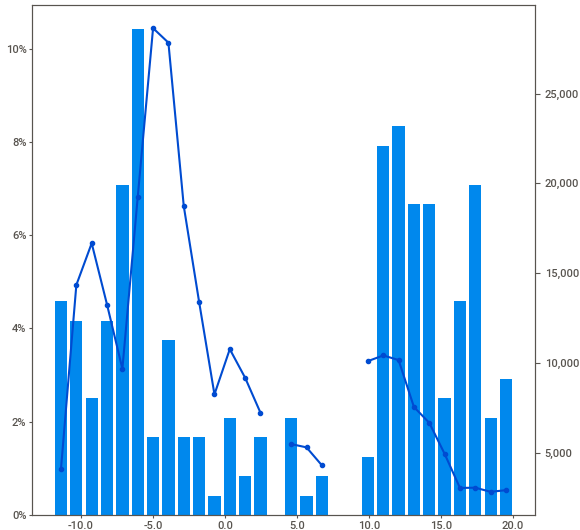
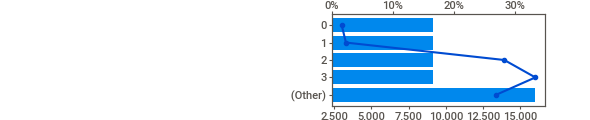
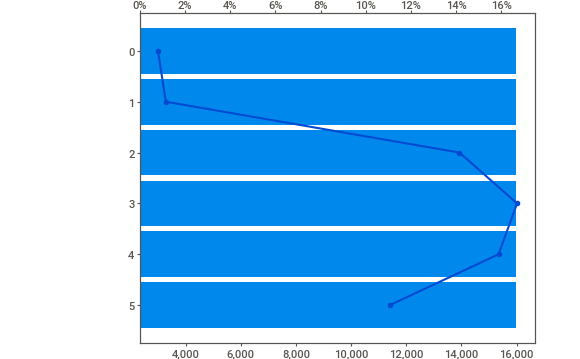
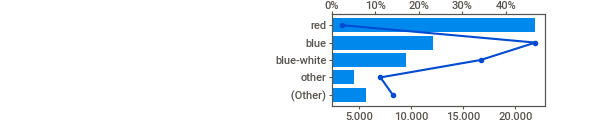
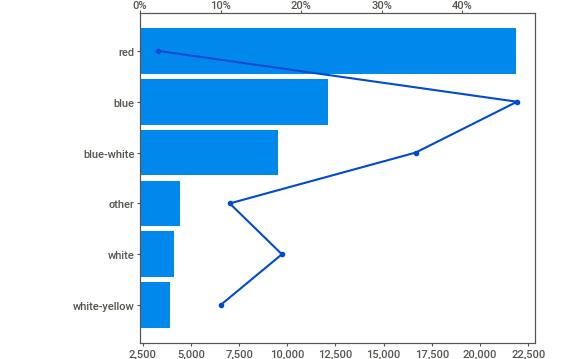
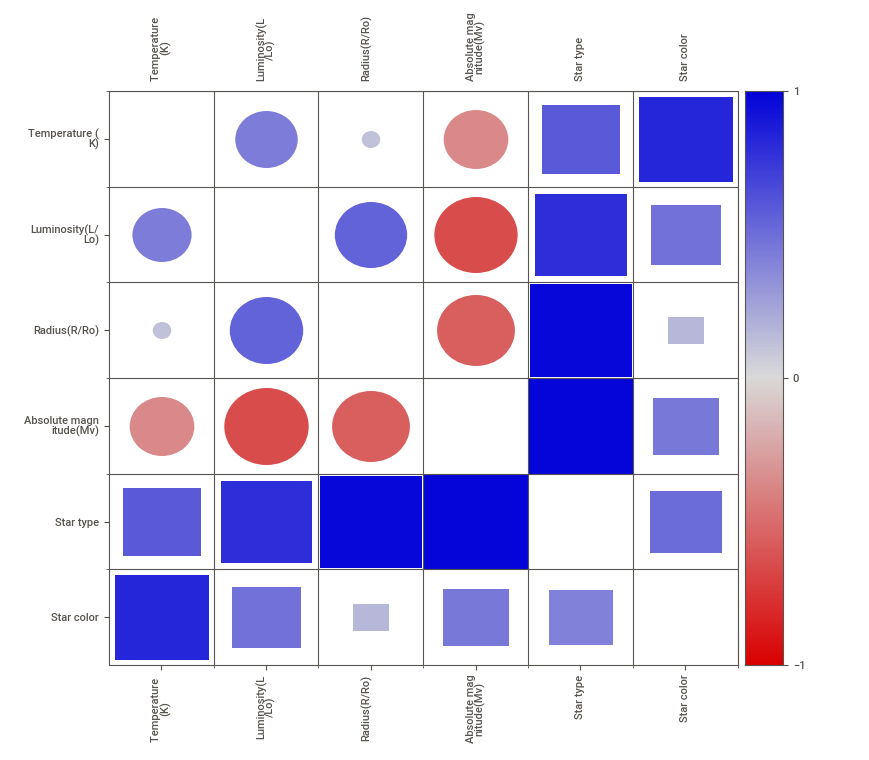
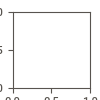

In [ ]:
report = sv.analyze([df, 'Target: Temperature (K)'], target_feat='Temperature (K)')
report.show_notebook(w=None, h=None, scale=0.9, layout='widescreen', filepath=None)

**Вывод по второму шагу:** избавились от лишнего столбца `Unnamed: 0`. Обнаружили выбросы в числовых данных, заменили их на среднее значение. Устранили неявные дубликаты в столбце `Star color`.

Исследовали корреляцию признаков, из чего можно сказать следующее:
- температура зависит от светимости с коэффициентом 0,56, при этом при светимости близкой к 0 зависимость меньше.
- температура мало зависит от радиуса, коэффициент корреляции равен 0,24.
- температура зависит от блеска с коэффициентом 0,71, при этом при температуре близкой к 0 зависимость меньше.
- температура зависит от типа звезды с коэффициентом 0,6, причем при 1-м и 2-ом типах температура не выше 5000 К, третий тип находится в диапазоне от 5 до 30 тыс. К.
- наибольшую корреляцию, равную 0,92, имеют тип звезды и её блеск. Видно, что нулевому типу соответствует светимость в диапазоне 15 - 20 Mv, первому и второму - 10 - 15 Mv, третьему - -10 - 10 Mv, четвертому - -7,5 - -5 Mv, пятому - -15 - -7,5 Mv.
- также высокую степень корреляции имеют тип звезды и её цвет. Коэффициент равен 0,86.
- радиус и цвет абсолютно не зависят друг от друга.

Провели исследовательский анализ всех данных, по результатам которого можем сделать следующие выводы:
- все числовые данные распределены не нормально
- чем больше относительная светимость звезды, тем больше её температура
- при максимальном относительном радиусе максимальна и температура
- наибольшая температура наблюдается при абсолютной звездной величине равной -5, влево и вправо от данного значения происходит падение температуры
- наибольшую температуру имеют звезды типа "Звёзды главной последовательности", наименьшую - "Коричневые карлики"
- синие звезды имеют наибольшую температуру, красные - наименьшую. И в целом звезды холодного спектра обладают более высокой температурой, чем звезды теплого спектра.

## Подготовка данных к построению модели

Зафиксируем все случайные параметры.

In [ ]:
torch.manual_seed(123)
torch.cuda.manual_seed(123)
np.random.seed(123)
torch.backends.cudnn.enabled=False
torch.backends.cudnn.deterministic=True

Выделим обучающие и целевой признаки.

In [ ]:
X = df.drop('Temperature (K)', axis=1)
y = df['Temperature (K)']

Разделим данные на тренировочные и тестовые.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=99)

Выполним масштабирование количественных признаков.

In [ ]:
scaler = StandardScaler()
X_train_num_scaled = pd.DataFrame(scaler.fit_transform(X_train[num_cols]),
                              columns=X_train[num_cols].columns,
                              index=X_train[num_cols].index)
X_test_num_scaled = pd.DataFrame(scaler.transform(X_test[num_cols]),
                             columns=X_test[num_cols].columns,
                             index=X_test[num_cols].index)

Произведем кодирование категориальных признаков.

In [ ]:
encoder = OneHotEncoder(drop='first')
X_train_cat = pd.DataFrame(encoder.fit_transform(X_train[cat_cols]).toarray(), columns=encoder.get_feature_names())
X_test_cat = pd.DataFrame(encoder.transform(X_test[cat_cols]).toarray(), columns=encoder.get_feature_names())

Склеим скалированные и кодированные данные.

In [ ]:
X_train = pd.concat([X_train_num_scaled.reset_index(drop=True), X_train_cat.reset_index(drop=True)], axis=1)
X_test = pd.concat([X_test_num_scaled.reset_index(drop=True), X_test_cat.reset_index(drop=True)], axis=1)
print(X_train.shape)
print(X_test.shape)

(180, 13)
(60, 13)


In [ ]:
X_train = torch.FloatTensor(X_train.values)
X_test = torch.FloatTensor(X_test.values)
y_train = torch.FloatTensor(y_train.values)
y_test = torch.FloatTensor(y_test.values)

**Вывод по третьему шагу:** разбили данные на тренировочные и тестовые. После чего стандартизировали числовые и закодировали категориальные признаки. В результате получили набор тренировочных признаков: 180 строк и 19 столбцов, а также набор тестовых признаков размером 60х19.

## Построение базовой нейронной сети

Зададим два списка для сохранения в них результатов работы нейросетей.

In [ ]:
best_rmses = []
best_epochs = []

Для дальнейшей работы зададим функции для тренировки, тестирования модели, инициализации весов и построения графика.

In [ ]:
def model_train(X_train, y_train):
    optimizer.zero_grad()
    preds = net.forward(X_train).flatten()
    l2_lambda = 0.001
    l2_norm = sum(p.pow(2.0).sum() for p in net.parameters())
    loss_value = torch.sqrt(loss(preds, y_train)) + l2_lambda * l2_norm
    loss_value.backward()
    optimizer.step()

In [ ]:
def model_test(X_test, y_test):
    net.eval()
    test_preds = net.forward(X_test).flatten()
    rmse = torch.sqrt(loss(test_preds, y_test)).item()
    print('Epoch number:', epoch)
    print('RMSE =', rmse, '\n')
    return test_preds, rmse

In [ ]:
def init_weights(layer):
    if type(layer) == nn.Linear:
        nn.init.kaiming_uniform_(
            layer.weight,
            mode='fan_in',
            nonlinearity='relu'
        )

In [ ]:
def graph(X, y, preds):
    plt.figure(figsize=(7, 7), dpi=200)
    plt.grid()
    my_range=range(1,21)
    plt.bar(my_range, preds[1:21].detach().numpy(), color='yellow', label='Прогноз')
    plt.bar(my_range, y[1:21], color='blue', width=0.5, label='Факт')
    plt.xticks(my_range)
    plt.legend()
    plt.title('График "Факт-Прогноз"', fontsize=14)
    plt.xlabel('Номер звезды')
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.ylabel('Температура звезды, К');


Создадим класс для задания архитектуры нейронной сети.
* Полносвязная нейронная сеть
* Два скрытых слоя
* Функции активации по слоям - `ReLU`

In [ ]:
class Net(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1,
                                    n_hidden_neurons_2, n_out_neurons):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = nn.ReLU()

        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.act2 = nn.ReLU()

        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
        self.act3 = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)

        x = self.fc2(x)
        x = self.act2(x)

        x = self.fc3(x)
        x = self.act3(x)
        return x

Зададим количество нейронов на слоях.

In [ ]:
n_in_neurons = X_train.shape[1]
n_hidden_neurons_1 = 8
n_hidden_neurons_2 = 8
n_out_neurons = 1

Инициализируем нейронную сеть.

In [ ]:
net = Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)

In [ ]:
net.apply(init_weights)

Net(
  (fc1): Linear(in_features=13, out_features=8, bias=True)
  (act1): ReLU()
  (fc2): Linear(in_features=8, out_features=8, bias=True)
  (act2): ReLU()
  (fc3): Linear(in_features=8, out_features=1, bias=True)
  (act3): ReLU()
)

Зададим оптимизатор функции потерь.

In [ ]:
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

loss = nn.MSELoss()

Выполним обучение и тестирование нейронной сети.

In [ ]:
num_epochs = 15001
best_rmse = 10000

for epoch in range(num_epochs):
    model_train(X_train, y_train)
    if epoch % 1000 == 0:
        preds, rmse = model_test(X_test, y_test)
        if rmse < best_rmse:
            best_rmse = rmse
            best_epoch = epoch
            best_preds = preds
best_rmses.append(best_rmse)
best_epochs.append(best_epoch)

Epoch number: 0
RMSE = 13751.9111328125 

Epoch number: 1000
RMSE = 12526.744140625 

Epoch number: 2000
RMSE = 8772.7470703125 

Epoch number: 3000
RMSE = 7237.5126953125 

Epoch number: 4000
RMSE = 6720.12109375 

Epoch number: 5000
RMSE = 6425.5029296875 

Epoch number: 6000
RMSE = 6008.94287109375 

Epoch number: 7000
RMSE = 5305.9296875 

Epoch number: 8000
RMSE = 4674.33544921875 

Epoch number: 9000
RMSE = 4710.89892578125 

Epoch number: 10000
RMSE = 4912.77001953125 

Epoch number: 11000
RMSE = 4965.77099609375 

Epoch number: 12000
RMSE = 4917.30859375 

Epoch number: 13000
RMSE = 4911.248046875 

Epoch number: 14000
RMSE = 4867.2666015625 

Epoch number: 15000
RMSE = 4794.1591796875 



Построим график «Факт — Прогноз» для предсказанной и фактической температуры звезд.

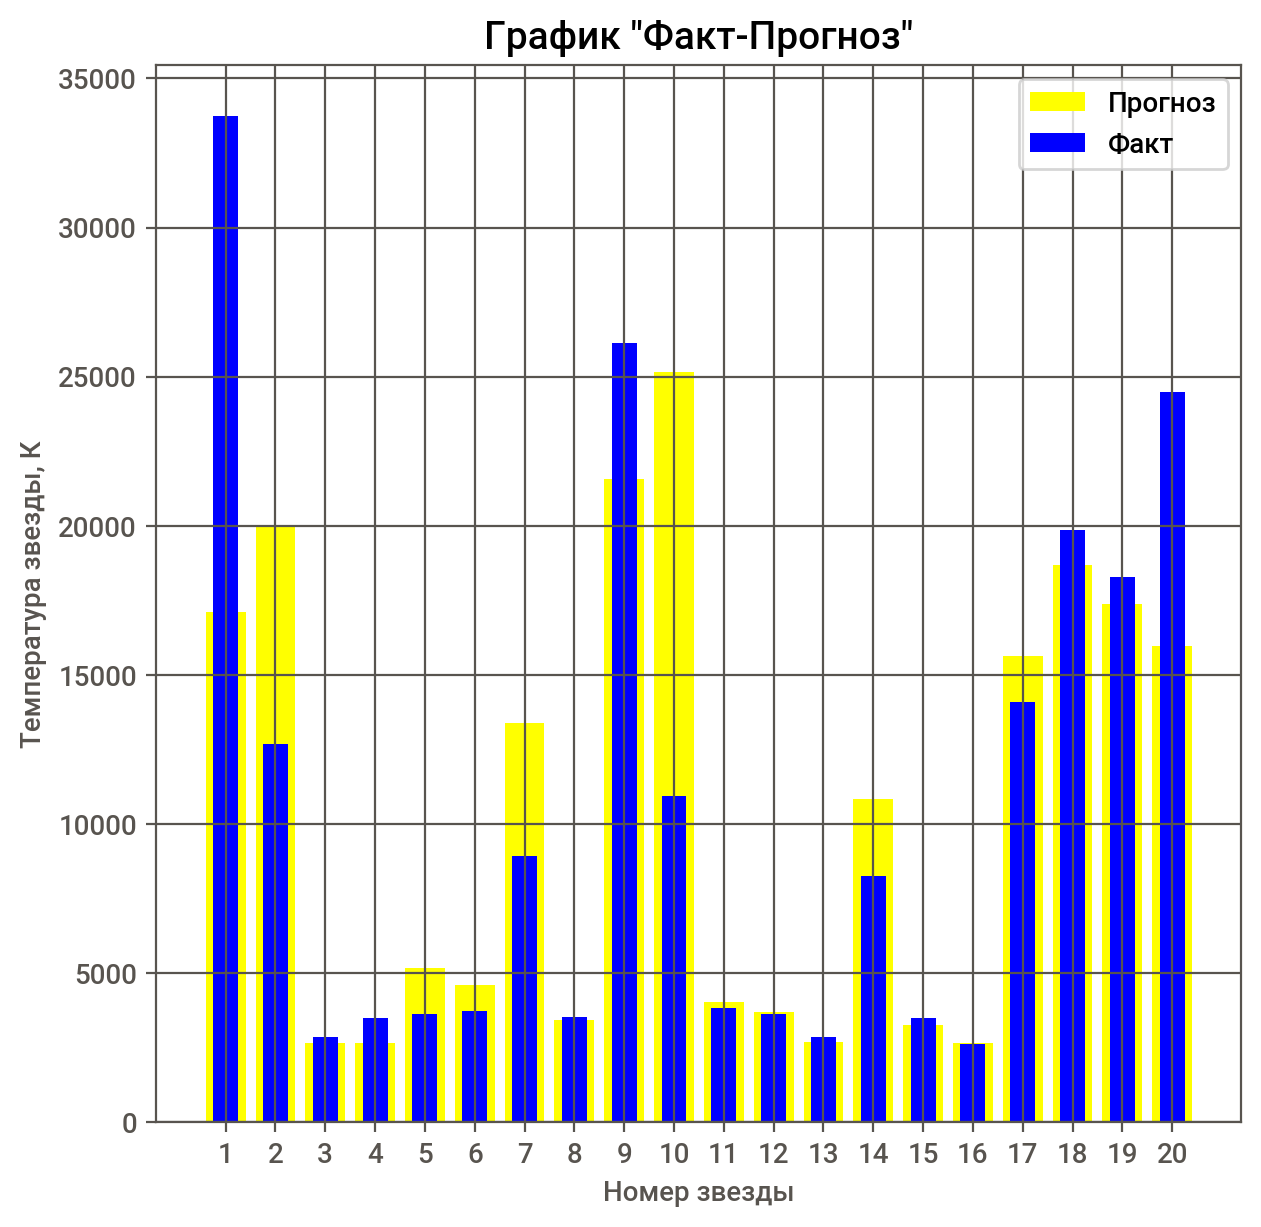

In [ ]:
graph(X_test, y_test, best_preds)

**Вывод по четвертому шагу:** создали класс для задания архитектуры нейронной сети. Задали количество скрытых слоёв, количество нейронов на них, функции активации на скрытых и выходном слоях. Провели обучение нейронной сети, получили метрику RMSE равную 4674 при количестве эпох равном 8000.

## Улучшение нейронной сети

Выполним улучшение нейронной сети, применив методы нормализации батчей и дропаут.

### Batch Normalization

Зададим класс с нормализацией батчей.

In [ ]:
class BatchNet(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1,
                                    n_hidden_neurons_2, n_out_neurons):
        super(BatchNet, self).__init__()

        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.bn1 = nn.BatchNorm1d(n_hidden_neurons_1)
        self.act1 = nn.ReLU()

        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.bn2 = nn.BatchNorm1d(n_hidden_neurons_2)
        self.act2 = nn.ReLU()

        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
        self.bn3 = nn.BatchNorm1d(n_out_neurons)
        self.act3 = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.act1(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = self.act2(x)

        x = self.fc3(x)
        x = self.bn3(x)
        x = self.act3(x)
        return x

Инициализируем нейронную сеть.

In [ ]:
net = BatchNet(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)
net.apply(init_weights)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

Вычислим метрику при количестве батчей равном 200, эпох - 15000.

In [ ]:
batch_size = 200
num_batches = ceil(len(X_train) / batch_size)
best_rmse = 10000

for epoch in range(num_epochs):
    order = np.random.permutation(len(X_train))
    for batch_idx in range(num_batches):
        start_idx = batch_idx * batch_size

        optimizer.zero_grad()

        batch_indexes = order[start_idx:start_idx + batch_size]
        X_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]

        model_train(X_batch, y_batch)
    if epoch % 1000 == 0:
        preds, rmse = model_test(X_test, y_test)
        if rmse < best_rmse:
            best_rmse = rmse
            best_epoch = epoch
            best_preds = preds
best_rmses.append(best_rmse)
best_epochs.append(best_epoch)

Epoch number: 0
RMSE = 13754.341796875 

Epoch number: 1000
RMSE = 7438.1787109375 

Epoch number: 2000
RMSE = 5736.43701171875 

Epoch number: 3000
RMSE = 5209.99560546875 

Epoch number: 4000
RMSE = 5166.07861328125 

Epoch number: 5000
RMSE = 4510.84375 

Epoch number: 6000
RMSE = 4158.8515625 

Epoch number: 7000
RMSE = 4263.07177734375 

Epoch number: 8000
RMSE = 4361.708984375 

Epoch number: 9000
RMSE = 4381.763671875 

Epoch number: 10000
RMSE = 4429.00634765625 

Epoch number: 11000
RMSE = 4440.7841796875 

Epoch number: 12000
RMSE = 4419.97021484375 

Epoch number: 13000
RMSE = 4417.734375 

Epoch number: 14000
RMSE = 4414.3408203125 

Epoch number: 15000
RMSE = 4427.76171875 



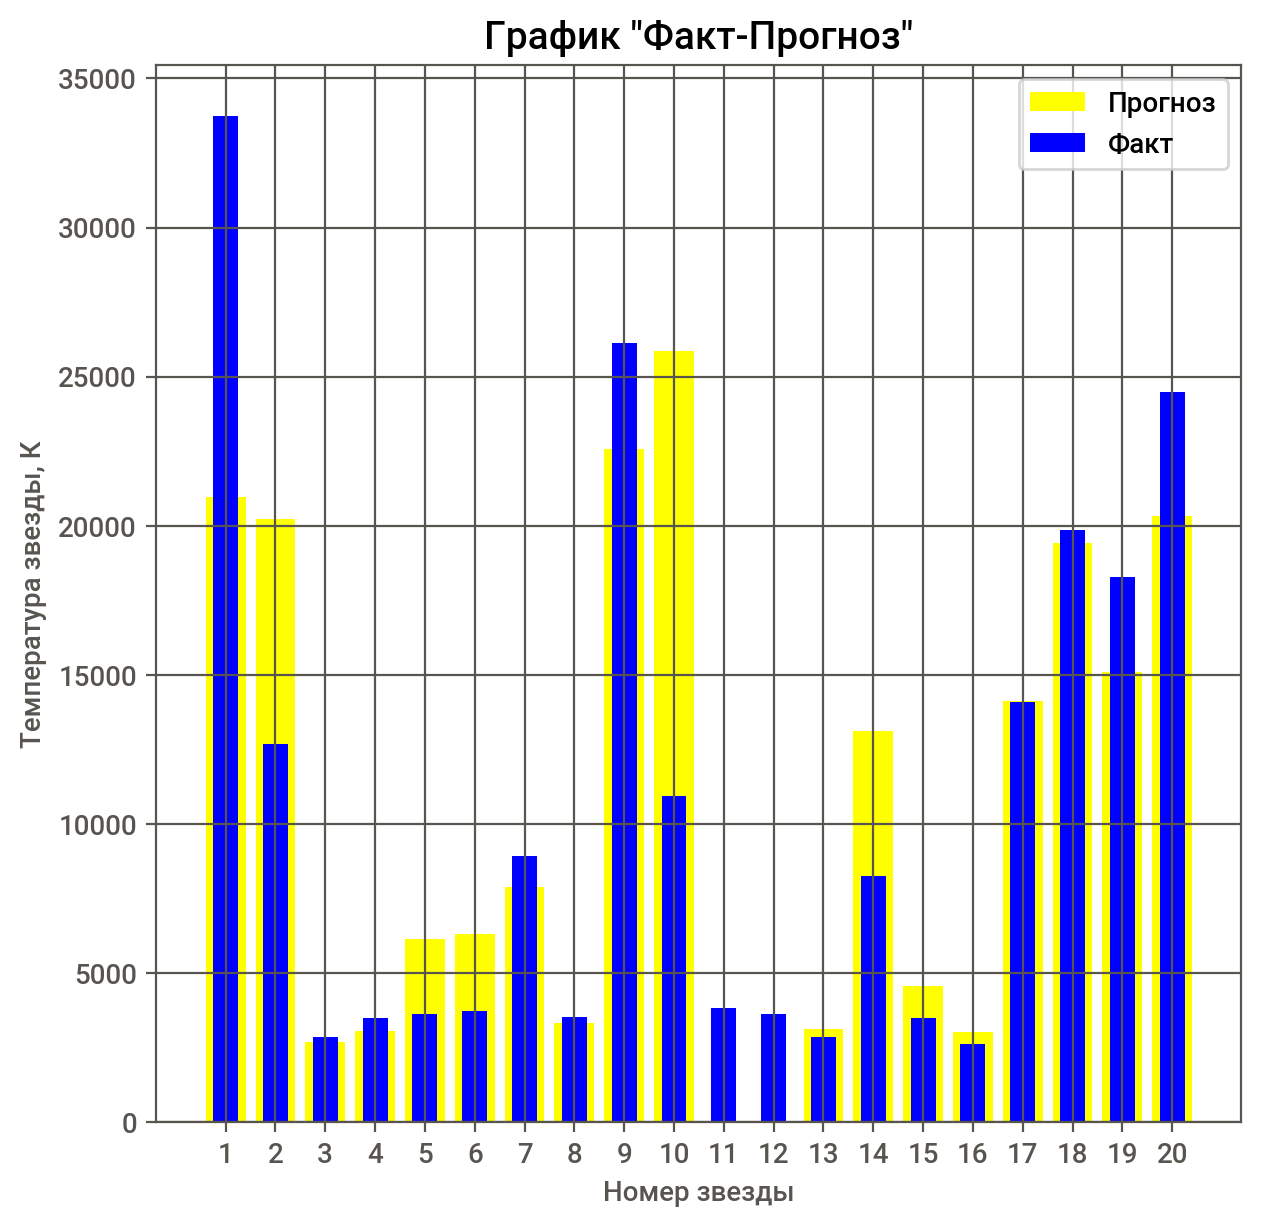

In [ ]:
graph(X_test, y_test, best_preds)

### Dropout

Зададим класс с выключением части нейронов.

In [ ]:
class DropoutNet(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1,
                                    n_hidden_neurons_2, n_out_neurons):
        super(DropoutNet, self).__init__()

        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.drop1 = nn.Dropout(p=0.6)
        self.act1 = nn.ReLU()

        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.drop2 = nn.Dropout(p=0.6)
        self.act2 = nn.ReLU()

        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
        self.act3 = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.drop1(x)
        x = self.act1(x)

        x = self.fc2(x)
        x = self.drop2(x)
        x = self.act2(x)

        x = self.fc3(x)
        x = self.act3(x)
        return x

Инициализируем нейронную сеть.

In [ ]:
net = DropoutNet(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)
net.apply(init_weights)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

Вычислим метрику с коэффициентом дропаута равным 0,6, эпох - 15000.

In [ ]:
best_rmse = 10000

for epoch in range(num_epochs):
    model_train(X_train, y_train)
    if epoch % 1000 == 0:
        preds, rmse = model_test(X_test, y_test)
        if rmse < best_rmse:
            best_rmse = rmse
            best_epoch = epoch
            best_preds = preds
best_rmses.append(best_rmse)
best_epochs.append(best_epoch)

Epoch number: 0
RMSE = 13753.9501953125 

Epoch number: 1000
RMSE = 13096.9462890625 

Epoch number: 2000
RMSE = 10050.9375 

Epoch number: 3000
RMSE = 7727.4853515625 

Epoch number: 4000
RMSE = 7061.5048828125 

Epoch number: 5000
RMSE = 6781.68310546875 

Epoch number: 6000
RMSE = 6562.18896484375 

Epoch number: 7000
RMSE = 6280.12841796875 

Epoch number: 8000
RMSE = 5824.5986328125 

Epoch number: 9000
RMSE = 5245.10791015625 

Epoch number: 10000
RMSE = 4853.23046875 

Epoch number: 11000
RMSE = 4768.51220703125 

Epoch number: 12000
RMSE = 4821.61767578125 

Epoch number: 13000
RMSE = 4873.9892578125 

Epoch number: 14000
RMSE = 5093.40478515625 

Epoch number: 15000
RMSE = 5179.14990234375 



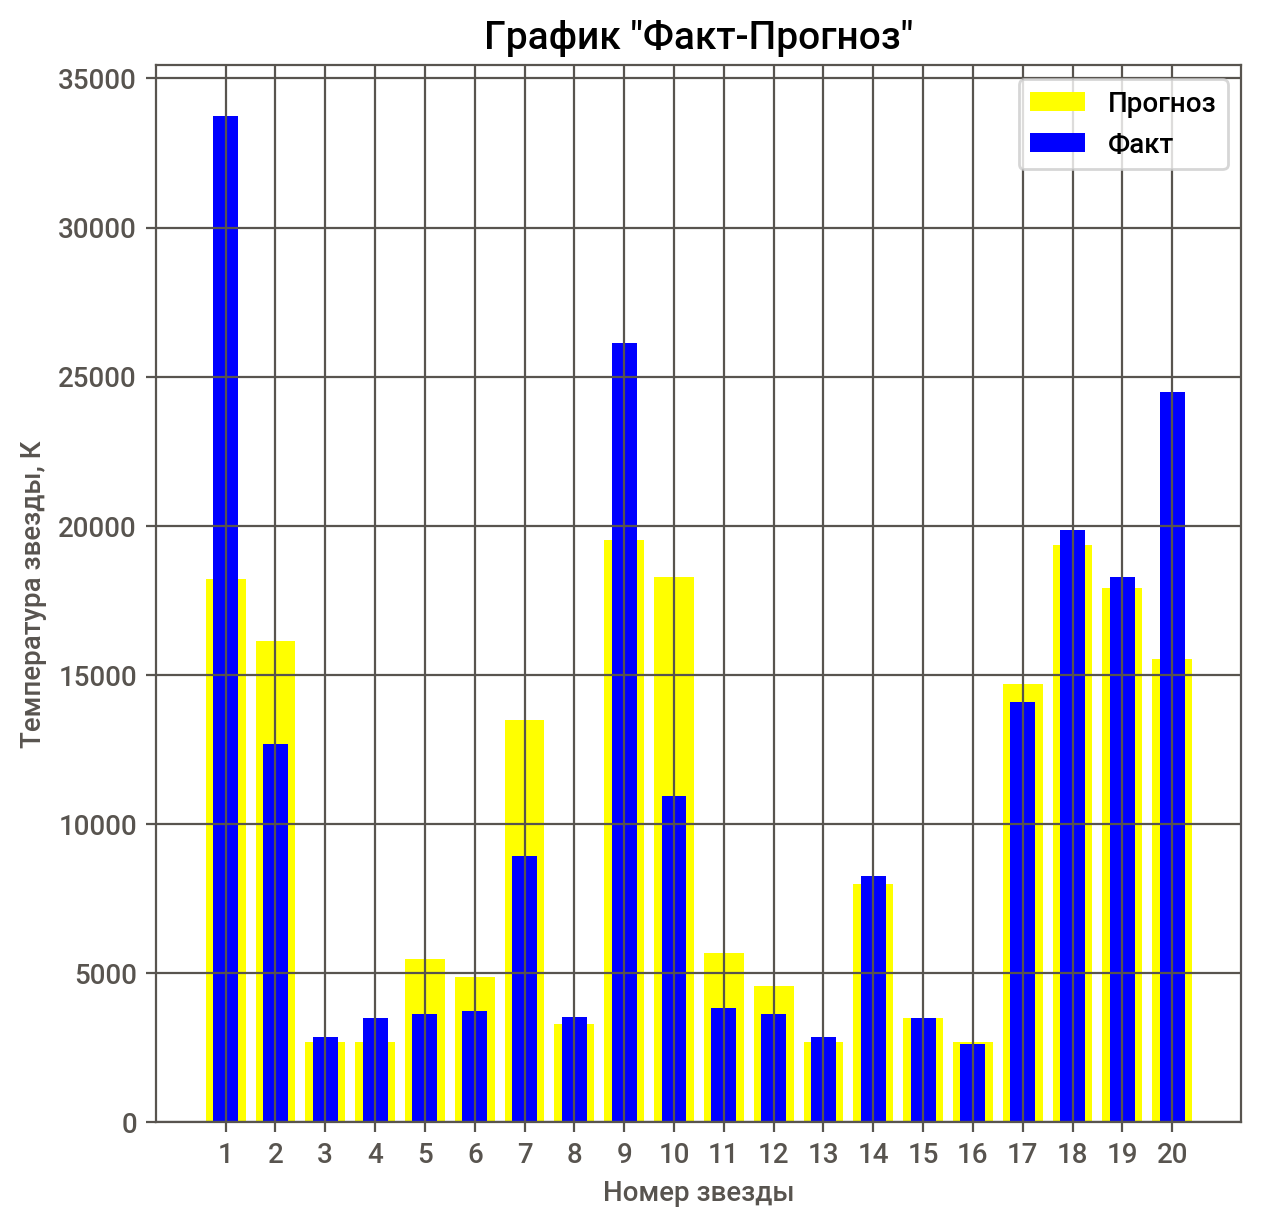

In [ ]:
graph(X_test, y_test, best_preds)

In [ ]:
result = pd.DataFrame({'Лучшая rmse': best_rmses, 'Эпоха': best_epochs}, index=['Baseline', 'Batch Normalization', 'Dropout'])
result

,Лучшая rmse,Эпоха
Baseline,4674.335449,8000
Batch Normalization,4158.851562,6000
Dropout,4768.512207,11000


**Вывод по пятому шагу:** применили методы нормализации батчей и дропаут. При нормализации батчей получили метрику равную 4159 на 6000 эпох. При дропауте получили метрику равную 4769 на 11000 эпох.

По соотношению метрики и количества эпох лучше всего себя показала модель с нормализацией батчей.

## Общий вывод

**Общий вывод:** Представленный датафрейм состоит из 240 строк и 7 столбцов, 3 из которых имеют тип float64, 3 - int64, 1 - object. Пропуски в колонках на первый взгляд отсутствуют. Столбец `Unnamed: 0` выглядит лишним, подробнее рассмотрим его в ледующем пункте. Далее перейдем к предобработке и исследовательскому анализу данных.

Далее избавились от лишнего столбца `Unnamed: 0`. Устранили неявные дубликаты в столбце `Star color`.

Исследовали корреляцию признаков, из чего можно сказать следующее:
- температура зависит от светимости с коэффициентом 0,56, при этом при светимости близкой к 0 зависимость меньше.
- температура мало зависит от радиуса, коэффициент корреляции равен 0,24.
- температура зависит от блеска с коэффициентом 0,71, при этом при температуре близкой к 0 зависимость меньше.
- температура зависит от типа звезды с коэффициентом 0,6, причем при 1-м и 2-ом типах температура не выше 5000 К, третий тип находится в диапазоне от 5 до 30 тыс. К.
- наибольшую корреляцию, равную 0,92, имеют тип звезды и её блеск. Видно, что нулевому типу соответствует светимость в диапазоне 15 - 20 Mv, первому и второму - 10 - 15 Mv, третьему - -10 - 10 Mv, четвертому - -7,5 - -5 Mv, пятому - -15 - -7,5 Mv.
- также высокую степень корреляции имеют тип звезды и её цвет. Коэффициент равен 0,86.
- радиус и цвет абсолютно не зависят друг от друга.

Провели исследовательский анализ всех данных, по результатам которого можем сделать следующие выводы:
- все числовые данные распределены не нормально
- чем больше относительная светимость звезды, тем больше её температура
- при максимальном относительном радиусе максимальна и температура
- наибольшая температура наблюдается при абсолютной звездной величине равной -5, влево и вправо от данного значения происходит падение температуры
- наибольшую температуру имеют звезды типа "Звёзды главной последовательности", наименьшую - "Коричневые карлики"
- синие звезды имеют наибольшую температуру, красные - наименьшую. И в целом звезды холодного спектра обладают более высокой температурой, чем звезды теплого спектра.

После чего разбили данные на тренировочные и тестовые. После чего стандартизировали числовые и закодировали категориальные признаки. В результате получили набор тренировочных признаков: 180 строк и 19 столбцов, а также набор тестовых признаков размером 60х19.

Затем создали класс для задания архитектуры нейронной сети. Задали количество скрытых слоёв, количество нейронов на них, функции активации на скрытых и выходном слоях. Провели обучение базовой нейронной сети, получили метрику RMSE равную 4674 при количестве эпох равном 8000.

Для улучшение нейронной сети применили методы нормализации батчей и дропаут. При нормализации батчей получили метрику равную 4159 на 6000 эпох. При дропауте получили метрику равную 4769 на 11000 эпох.

По соотношению метрики и количества эпох лучше всего себя показала модель с нормализацией батчей.

